In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (10, 10)
blue = (43, 156, 212)
red = (212, 100, 100)
orange = (249, 182, 118)
green = (43, 212, 156)

def constrain(val, min_val, max_val):
    return min(max(val, min_val), max_val)

In [3]:
# paths = ['dice1.jpg', 'dice2.jpg', 'dice4.jpg']
paths = ['ten-3.png']

In [54]:
results = []
for i, path in enumerate(paths):
    sub_results = {}

    img = cv2.imread('../imgs/{}'.format(path))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sub_results['01-gray'] = img_gray

    blurred = cv2.blur(img_gray, (20, 20))
    sub_results['02-blurred'] = blurred

    # white dice on black
    # retval, threshold = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)
    # black dice on white
    retval, threshold = cv2.threshold(img_gray, 70, 255, cv2.THRESH_BINARY_INV)
    sub_results['03-threshold'] = threshold

    resized = cv2.resize(threshold, (200, 200))
    eroded = cv2.erode(threshold, (2, 2), iterations = 3)
    sub_results['04-eroded'] = eroded

    threshold, contours, hierarchy = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     cv2.drawContours(img, contours, -1, orange, cv2.LINE_AA)

    for c, contour in enumerate(contours):
        # dice min area (rotated rect)
        rect_min_area = cv2.minAreaRect(contour)
        rect_min_points = cv2.boxPoints(rect_min_area)
        rect_min_box = np.int0(rect_min_points)
        cv2.drawContours(img, [rect_min_box], 0, red, cv2.LINE_AA)
        sub_results['05-img'] = img

        # bounding rect of the *min area rect*
        rrb = cv2.boundingRect(rect_min_points)
        rrb_tl = rrb[0:2]
        rrb_br = tuple([sum(x) for x in zip(rrb_tl, rrb[2:4])])
        cv2.rectangle(img, rrb_tl, rrb_br, blue, 3, cv2.LINE_AA)
        
        # get cropped to bounding rect
        y_start = constrain(rrb_tl[1], 0, img.shape[1])
        y_end =   constrain(rrb_br[1], 0, img.shape[1])
        
        x_start = constrain(rrb_tl[0], 0, img.shape[0])
        x_end =   constrain(rrb_br[0], 0, img.shape[1])
        
        cropped = eroded[y_start:y_end, x_start:x_end]
        sub_results['06-cropped'] = cropped
        
        # do rotation
        rect_min_width = int(rect_min_area[1][0] - rect_min_area[0][0])
        rect_min_height = int(rect_min_area[1][1] - rect_min_area[0][1])

        keep = rect_min_area[2] > -45
        width = int(rect_min_area[1][0 if keep else 1])
        height = int(rect_min_area[1][1 if keep else 0])
        angle = rect_min_area[2] + (0 if keep else 90)
        center = (width / 2, height / 2)

        scale = 1
        dsize = (width * scale, height * scale)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        straight = cv2.warpAffine(cropped, matrix, dsize)
        sub_results['07-straight'] = straight

#         straight_col = cv2.cvtColor(straight, cv2.COLOR_GRAY2BGR)
#         t, cc, h = cv2.findContours(straight, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#         biggest = max(cc, key=lambda c: cv2.contourArea(c))

#         bb = cv2.boundingRect(biggest)
#         straight_crop = straight[
#             bb[1]:bb[1] + bb[3],
#             bb[0]:bb[0] + bb[2]
#         ]
#         cv2.drawContours(straight_col, cc, -1, orange, cv2.LINE_AA)
#         sub_results['08-straight_col'] = straight_col

#         filename = 'output/{}-{}.png'.format(path, str(c).zfill(2))
#         cv2.imwrite(filename, straight_crop)
#         print('wrote to {}'.format(filename))
#         sub_results['09-straight_crop'] = straight_crop

        results.append(sub_results)


TypeError: 'int' object is not subscriptable

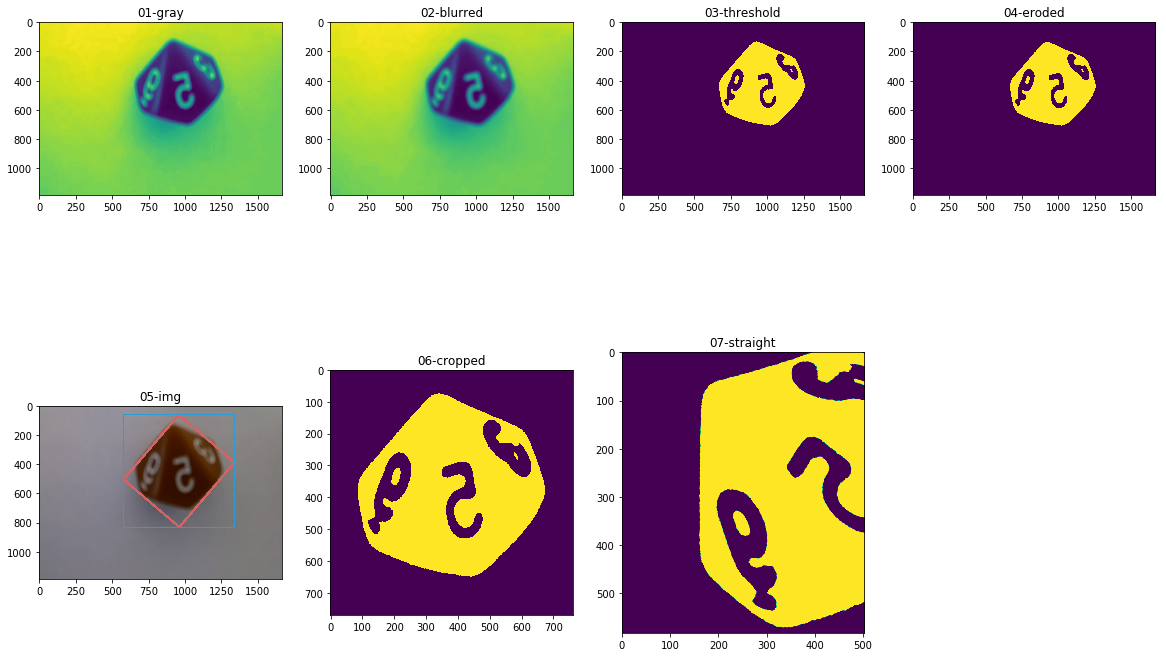

In [53]:
# print(results[0].keys())
fig = plt.figure()
plt.rcParams['figure.figsize'] = (20, 20)
for result in results:
    c = 1
    for k, v in result.items():
        a = fig.add_subplot(3, 4, c)
        c += 1
        plt.imshow(v)
        a.set_title(k)
    